In [373]:
%matplotlib inline
import talib as ta
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm

In [395]:
class TALibVolumeStudies:
    
    def ChaikinAD(self, high, low, close, volume, feature_dict):
        feature_dict['ChaikinAD']='Keep'
        chaikinAD = ta.AD(
            high,
            low,
            close, 
            volume)
        return chaikinAD, feature_dict
    
    def ChaikinADOSC(self, high, low, close, volume, fastperiod, slowperiod, feature_dict):
        feature_dict['ChaikinADOSC_f'+str(fastperiod)+'_s'+str(slowperiod)]='Keep'
        chaikinADOSC = ta.ADOSC(
            high,
            low,
            close, 
            volume,
            fastperiod,
            slowperiod)
        return chaikinADOSC, feature_dict
    
    def OBV(self, close, volume, feature_dict):
        feature_dict['OBV']='Keep'
        onBalVol = ta.OBV(
            close, 
            volume)
        return onBalVol, feature_dict
    
    def MFI(self, dataSet, period, feature_dict):
        """
            Money Flow Index (MFI)
            Uses both price and volume to measure buying and selling pressure. It is
            positive when the typical price rises (buying pressure) and negative when
            the typical price declines (selling pressure). A ratio of positive and
            negative money flow is then plugged into an RSI formula to create an
            oscillator that moves between zero and one hundred.
            http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:money_flow_index_mfi
            Args:
                dataSet: Price series dataet
                n(int): n period.
            Returns:
                dataSet: Dataset with new feature generated.
        """
        col_name = 'MFI_'+ str(period)
        feature_dict[col_name]='Keep'
        dataSet['Up_or_Down'] = 0
        dataSet.loc[(dataSet['Close'] > dataSet['Close'].shift(1)), 'Up_or_Down'] = 1
        dataSet.loc[(dataSet['Close'] < dataSet['Close'].shift(1)), 'Up_or_Down'] = 2

        # 1 typical price
        tp = (dataSet['High'] + dataSet['Low'] + dataSet['Close']) / 3.
        
        # 2 money flow
        mf = tp * dataSet['Volume']

        # 3 positive and negative money flow with n periods
        dataSet['1p_Positive_Money_Flow'] = 0.0
        dataSet.loc[dataSet['Up_or_Down'] == 1, '1p_Positive_Money_Flow'] = mf
        n_positive_mf = dataSet['1p_Positive_Money_Flow'].rolling(period).sum()

        dataSet['1p_Negative_Money_Flow'] = 0.0
        dataSet.loc[dataSet['Up_or_Down'] == 2, '1p_Negative_Money_Flow'] = mf
        n_negative_mf = dataSet['1p_Negative_Money_Flow'].rolling(period).sum()
        dataSet = dataSet.drop(['1p_Positive_Money_Flow','Up_or_Down','1p_Negative_Money_Flow'], axis=1)  
        
        # 4 money flow index
        mr = n_positive_mf / n_negative_mf
        mr = (100 - (100 / (1 + mr)))
        dataSet[col_name] = mr
        return dataSet, feature_dict
    
    def Centered(self, df, col, feature_dict, lb=14, type='median'):
        """
            Center - subtract a historical median from signal,
            use the pandas sliding window functions.
            Args:
                dataSet: Time series dataset
                col: Column name to be centered
                feature_dict: Dictionary of added features
                lb(int): lookback period
                type: default is median, col
            Returns:
                dataSet: Dataset with new feature generated.
                feature_dict: Append entry with colname
        """
        col_name = str(col) + '_Centered'
        feature_dict[col_name] = 'Keep'
        df[col_name] = df[col]
        if type == 'median':
            rm = df[col].rolling(window=lb, center=False).median()
            df[col_name] = df[col] - rm
        return df, feature_dict
    
    def Scaled(self, df, col, feature_dict):
        """
            Scaled - Use when sign and magnitude is of paramount importance.
            Scale accoring to historical volatility defined by interquartile range.
            Args:
                df: Signal to be centered
                col: Column name to be centered
                feature_dict: Dictionary of added features
                lb(int): lookback period
                type: default is median, col
            Returns:
                dataSet: Dataset with new feature generated.
                feature_dict: Append entry with colname
        """
        col_name = str(col) + '_Scaled'
        feature_dict[col_name] = 'Keep'
        df[col_name] = df[col]
        scaler = RobustScaler(quantile_range=(25, 75))
        df[[col_name]] = scaler.fit_transform(df[[col_name]])
        return df, feature_dict


    def get_NormArrayOrig(self, df, n, mode = 'total', linear = False):
        '''
                 It computes the normalized value on the stats of n values ( Modes: total or scale ) 
                 using the formulas from the book "Statistically sound machine learning..."
                 (Aronson and Masters) but the decission to apply a non linear scaling is left to the user.
                 It is modified to fit the data from -1 to 1 instead of -100 to 100
                 df is an imput DataFrame. it returns also a DataFrame, but it could return a list.
                 n define the number of data points to get the mean and the quartiles for the normalization
                 modes: scale: scale, without centering. total:  center and scale.
         '''
        temp =[]

        for i in range(len(df))[::-1]:

            if i  >= n: # there will be a traveling norm until we reach the initian n values. 
                        # those values will be normalized using the last computed values of F50,F75 and F25
                F50 = df[i-n:i].quantile(0.5)
                F75 =  df[i-n:i].quantile(0.75)
                F25 =  df[i-n:i].quantile(0.25)

            if linear == True and mode == 'total':
                 v = 0.5 * ((df.iloc[i]-F50)/(F75-F25))-0.5
            elif linear == True and mode == 'scale':
                 v =  0.25 * df.iloc[i]/(F75-F25) -0.5
            elif linear == False and mode == 'scale':
                 v = 0.5* norm.cdf(0.25*df.iloc[i]/(F75-F25))-0.5

            else: # even if strange values are given, it will perform full normalization with compression as default
                v = norm.cdf(0.5*(df.iloc[i]-F50)/(F75-F25))-0.5
            #print(v)
            temp.append(v)
        #print(temp)
        return  temp[::-1]
    
    def get_NormArray50(self, df, n, mode = 'total', linear = True):
        '''
                 It computes the normalized value on the stats of n values ( Modes: total or scale ) 
                 using the formulas from the book "Statistically sound machine learning..."
                 (Aronson and Masters) but the decission to apply a non linear scaling is left to the user.
                 It is modified to fit the data from -1 to 1 instead of -100 to 100
                 df is an imput DataFrame. it returns also a DataFrame, but it could return a list.
                 n define the number of data points to get the mean and the quartiles for the normalization
                 modes: scale: scale, without centering. total:  center and scale.
         '''
        temp =[]

        for i in range(len(df))[::-1]:

            if i  >= n: # there will be a traveling norm until we reach the initian n values. 
                        # those values will be normalized using the last computed values of F50,F75 and F25
                F50 = df[i-n:i].quantile(0.5)
                F75 =  df[i-n:i].quantile(0.75)
                F25 =  df[i-n:i].quantile(0.25)

                F25 =  df[i-n:i].quantile(0.25)

            if linear == True and mode == 'total':
                 v = 50 * ((df.iloc[i]-F50)/(F75-F25))-50
            elif linear == True and mode == 'scale':
                 v =  25 * df.iloc[i]/(F75-F25) -50
            elif linear == False and mode == 'scale':
                 v = 100 * norm.cdf(0.5*df.iloc[i]/(F75-F25))-50

            else: # even if strange values are given, it will perform full normalization with compression as default
                v = norm.cdf(50*(df.iloc[i]-F50)/(F75-F25))-50
            #print(v)
            temp.append(v)
        #print(temp)
        return  temp[::-1]
    
    def get_NormArray(self, dataSet, colname, n, feature_dict, mode = 'scale', linear = False):
        '''
                 It computes the normalized value on the stats of n values ( Modes: total or scale ) 
                 using the formulas from the book "Statistically sound machine learning..."
                 (Aronson and Masters) but the decission to apply a non linear scaling is left to the user.
                 It is modified to fit the data from -1 to 1 instead of -100 to 100
                 df is an imput DataFrame. it returns also a DataFrame, but it could return a list.
                 n define the number of data points to get the mean and the quartiles for the normalization
                 modes: scale: scale, without centering. total:  center and scale.
         '''
        temp =[]
        new_colname = str(colname) + '_Normalized'
        feature_dict[new_colname] = 'Keep'
        
        df = dataSet[colname]
        #print(df)

        for i in range(len(df))[::-1]:

            if i  >= n: # there will be a traveling norm until we reach the initian n values. 
                        # those values will be normalized using the last computed values of F50,F75 and F25
                F50 = df[i-n:i].quantile(0.5)
                F75 =  df[i-n:i].quantile(0.75)
                F25 =  df[i-n:i].quantile(0.25)

            if linear == True and mode == 'total':
                 v = 50 * ((df.iloc[i]-F50)/(F75-F25))-50
            elif linear == True and mode == 'scale':
                 v =  25 * df.iloc[i]/(F75-F25) -50
            elif linear == False and mode == 'scale':
                 v = 100 * norm.cdf(0.5*df.iloc[i]/(F75-F25))-50

            else: # even if strange values are given, it will perform full normalization with compression as default
                v = norm.cdf(50*(df.iloc[i]-F50)/(F75-F25))-50
            #print(v)
            temp.append(v)
        #print(temp)
        dataSet[new_colname] = temp[::-1]
        return  dataSet, feature_dict

In [396]:
import sys
sys.path.append('./lib')
sys.path.append('./utilities')
from plot_utils import *
from retrieve_data import *
dataLoadStartDate = "2014-04-01"
dataLoadEndDate = "2018-04-01"
issue = "TLT"
feature_dict = {}

taLibVolSt = TALibVolumeStudies()
    
dSet = DataRetrieve()
dataSet = dSet.read_issue_data(issue)
dataSet['Date'] = pd.to_datetime(dataSet['Date']) 
dataSet = dSet.set_date_range(dataSet, dataLoadStartDate,dataLoadEndDate)

Successfully retrieved data series for TLT


In [397]:
dataSet['ChaikinAD'], feature_dict = taLibVolSt.ChaikinAD(dataSet.High.values, dataSet.Low.values, dataSet.Pri.values, dataSet.Volume, feature_dict)



In [398]:
dataSet, feature_dict = taLibVolSt.Scaled(dataSet, 'ChaikinAD', feature_dict)
#print(feature_dict)

dataSet, feature_dict = taLibVolSt.Centered(dataSet, 'ChaikinAD', feature_dict, 14)
#print(feature_dict)

In [399]:
dataSet, feature_dict = taLibVolSt.MFI(dataSet, 50, feature_dict)
#print(feature_dict)

In [400]:

dataSet, feature_dict = taLibVolSt.get_NormArray(dataSet, 'ChaikinAD', 200, feature_dict, mode='scale', linear=False)
dataSet['CAD_Normalized1'] = taLibVolSt.get_NormArray50(dataSet.ChaikinAD, 200, mode='scale',linear=False)
dataSet['CAD_Normalized2'] = taLibVolSt.get_NormArrayOrig(dataSet.ChaikinAD, 200, mode='scale',linear=False)

#print(feature_dict)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


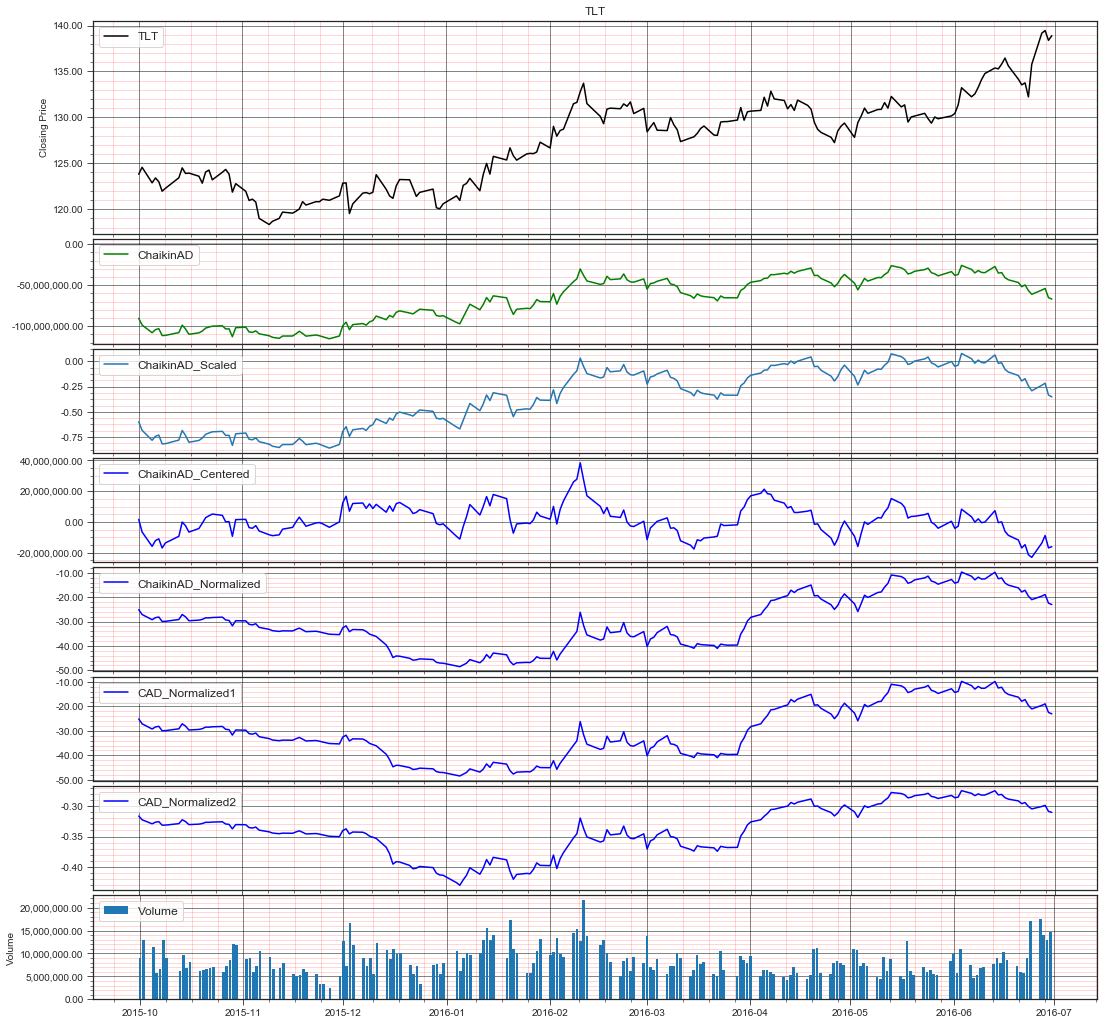

In [401]:
startDate = "2015-10-01"
endDate = "2016-06-30"
rsiDataSet = dataSet.ix[startDate:endDate]
plt.figure(figsize=(18,18))
horizplots = 9
top = plt.subplot2grid((horizplots,4), (0, 0), rowspan=2, colspan=4)
middle = plt.subplot2grid((horizplots,4), (2, 0), rowspan=1, colspan=4)
middle2 = plt.subplot2grid((horizplots,4), (3, 0), rowspan=1, colspan=4)
middle3 = plt.subplot2grid((horizplots,4), (4, 0), rowspan=1, colspan=4)
middle4 = plt.subplot2grid((horizplots,4), (5, 0), rowspan=1, colspan=4)
middle5 = plt.subplot2grid((horizplots,4), (6, 0), rowspan=1, colspan=4)
middle6 = plt.subplot2grid((horizplots,4), (7, 0), rowspan=1, colspan=4)
bottom = plt.subplot2grid((horizplots,4), (8, 0), rowspan=1, colspan=4)

top.plot(rsiDataSet.index, rsiDataSet['Pri'], 'k-', markersize=3,label=issue)
middle.plot(rsiDataSet.index, rsiDataSet['ChaikinAD'], 'g-')
middle2.plot(rsiDataSet.index, rsiDataSet['ChaikinAD_Scaled'], '-')
#middle3.plot(rsiDataSet.index, rsiDataSet['MFI_14'], 'b-')
middle3.plot(rsiDataSet.index, rsiDataSet['ChaikinAD_Centered'], 'b-')
middle4.plot(rsiDataSet.index, rsiDataSet['ChaikinAD_Normalized'], 'b-')
middle5.plot(rsiDataSet.index, rsiDataSet['CAD_Normalized1'], 'b-')
middle6.plot(rsiDataSet.index, rsiDataSet['CAD_Normalized2'], 'b-')
bottom.bar(rsiDataSet.index, rsiDataSet['Volume'], label='Volume')

plt.subplots_adjust(hspace=0.05)
# set the labels
top.axes.get_xaxis().set_visible(True)
top.set_title('TLT')
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')

#top.axhline(y=30, color='red', linestyle='-', alpha=0.4)
#top.axhline(y=70, color='blue', linestyle='-', alpha=0.4)
middle.axhline(y=0, color='black', linestyle='-', alpha=0.4)

for ax in top, middle, middle2, middle3, middle4, middle5, middle6, bottom:
                ax.label_outer()
                ax.legend(loc='upper left', frameon=True, fontsize=12)
                ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
                ax.grid(True, which='both')
                ax.xaxis_date()
                ax.autoscale_view()
                ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.6)
                ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
                ax.minorticks_on()

In [ ]:
print(feature_dict)